In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/data')

In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (181 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!pip install uv
!uv pip install --system colpali-engine>=0.3.4 pdf2image torch transformers>=4.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 98.8 MB/s eta 0:00:00
Using Python 3.11.12 environment at: /usr
Resolved 44 packages in 455ms
⠙ Preparing packages... (0/12)
⠙ Preparing packages... (0/12)
⠙ Preparing packages... (0/12)
pdf2image              ------------------------------     0 B/11.35 KiB
⠙ Preparing packages... (0/12)
pdf2image                ------------------------------     0 B/11.35 KiB
⠙ Preparing packages... (0/12)
pdf2image                ------------------------------     0 B/11.35 KiB
⠙ Preparing packages... (0/12)
pdf2image                ------------------------------     0 B/11.35 KiB
nvidia-cuda-runtime-cu12 ------------------------------     0 B/863.02 KiB
⠙ Preparing packages... (0/12)
pdf2image                ------------------------------     0 B/11.35 KiB
nvidia-cuda-runtime-cu12 ------------------------------     0 B/863.02 KiB
⠙ Preparing packages... (0/12)
pdf2image                ------------------------------ 11.35 KiB/11.35 KiB
nvidia-

In [ ]:
# import os
# from pathlib import Path
# import objects
# from RAGModel import RAGMultiModalModel
# from google.colab import userdata

# HF_TOKEN = userdata.get('HF_TOKEN')

# model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0")

In [ ]:
# !wget https://arxiv.org/pdf/1706.03762
# !mkdir docs
# !mv 1706.03762 docs/attention.pdf
# !cp -r docs/attention.pdf docs/attention_with_a_mustache.pdf

In [ ]:
# # Test indexing
# metadata = [{"filename":file_name} for file_name in os.listdir("docs")]

# index_name = "attention_index"
# model.index(
#     input_path=Path("docs/"),
#     index_name=index_name,
#     store_collection_with_index=False,
#     metadata=metadata,
#     overwrite=True
# )

# # BLEU tables are on page 8 and 9. We've indexed the pdf and its evil mustached twin, so we should see similar scores occur twice for every relevant page.
# query = "what's the BLEU score of this new strange method?"
# results = model.search(query, k=5)

# print(f"Search results for '{query}':")
# for result in results:
#     print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}")

# print("Test completed successfully!")

In [ ]:
# %%timeit
# model.search(query, k=3)

In [ ]:
# model = RAGMultiModalModel.from_index("attention_index")

In [ ]:
# results = model.search(query, k=5)

# print(f"Search results for '{query}':")
# for result in results:
#     print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}")

In [ ]:
import json
from pathlib import Path
import shutil
from typing import List, Dict, Any, Set
import gc
from RAGModel import RAGMultiModalModel
from objects import Result
import torch

QA_JSON_PATH = Path("/content/drive/MyDrive/data/generated_qa_pairs_new.json")
PDF_SOURCE_DIR = Path("/content/drive/MyDrive/data/pdfs")
INDEX_ROOT_DIR = Path(".rag_eval_indexes")
BASE_MODEL_NAME = "vidore/colpali-v1.2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K_FOR_RETRIEVAL = 5
OVERWRITE_EXISTING_INDEXES = False

def load_qa_data(json_path: Path) -> List[Dict[str, Any]]:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def get_unique_pdf_sources(qa_data: List[Dict[str, Any]]) -> Set[str]:
    sources = set()
    for item in qa_data:
        sources.add(item["source"])
    return sources

def main():
    print("Bắt đầu quá trình đánh giá RAG Pipeline...")

    if not QA_JSON_PATH.exists():
        print(f"Lỗi: Không tìm thấy file JSON dữ liệu QA tại: {QA_JSON_PATH}")
        return

    qa_data = load_qa_data(QA_JSON_PATH)
    if not qa_data:
        print("Không có dữ liệu QA để xử lý.")
        return

    unique_sources = get_unique_pdf_sources(qa_data)
    print(f"Tìm thấy {len(unique_sources)} file PDF nguồn duy nhất để xử lý.")

    INDEX_ROOT_DIR.mkdir(parents=True, exist_ok=True)

    for source_name_stub in unique_sources:
        pdf_file_name = source_name_stub + ".pdf"
        pdf_file_path = PDF_SOURCE_DIR / pdf_file_name
        specific_index_name = f"index_{source_name_stub}"

        if not pdf_file_path.exists():
            print(f"!!! Cảnh báo: Không tìm thấy file PDF {pdf_file_path} cho source '{source_name_stub}'. Bỏ qua indexing cho file này.")
            continue

        index_path_full = INDEX_ROOT_DIR / specific_index_name

        if OVERWRITE_EXISTING_INDEXES and index_path_full.exists():
            print(f"Overwrite được bật. Xóa index cũ: {index_path_full}")
            shutil.rmtree(index_path_full)

        if not index_path_full.exists():
            print(f"Index cho '{source_name_stub}' tại '{specific_index_name}' chưa tồn tại hoặc cần overwrite. Bắt đầu indexing...")
            rag_indexer = None
            try:
                rag_indexer = RAGMultiModalModel.from_pretrained(
                    BASE_MODEL_NAME,
                    index_root=str(INDEX_ROOT_DIR),
                    device=DEVICE,
                    verbose=1
                )
                rag_indexer.index(
                    input_path=pdf_file_path,
                    index_name=specific_index_name,
                    overwrite=True,
                    store_collection_with_index=False
                )
                print(f"Đã index xong cho '{source_name_stub}' vào '{specific_index_name}'.")
            except Exception as e:
                print(f"Lỗi khi indexing cho '{source_name_stub}': {e}")
            finally:
                if rag_indexer and hasattr(rag_indexer, 'model') and rag_indexer.model:
                    del rag_indexer.model.model
                    del rag_indexer.model.processor
                    del rag_indexer.model
                    del rag_indexer
                gc.collect()
                if DEVICE == "cuda":
                    torch.cuda.empty_cache()
                print(f"Đã dọn dẹp bộ nhớ sau khi index '{source_name_stub}'.")
        else:
            print(f"Sử dụng index đã có cho '{source_name_stub}' tại '{specific_index_name}'.")

    print("\n--- Bắt đầu bước đánh giá Retrieval ---")
    total_questions = 0
    processed_questions_count = 0
    hit_at_k_count = 0
    mrr_sum = 0.0

    for i, qa_pair in enumerate(qa_data):
        question = qa_pair["question"]
        gt_source_name_stub = qa_pair["source"]
        gt_page_numbers: List[int] = qa_pair["page_numbers"]

        print(f"\nĐánh giá câu hỏi {i+1}/{len(qa_data)}: (Source: {gt_source_name_stub}) \"{question[:60]}...\"")
        total_questions +=1

        current_index_name = f"index_{gt_source_name_stub}"
        full_current_index_path = INDEX_ROOT_DIR / current_index_name

        if not full_current_index_path.exists():
            print(f"!!! Lỗi: Không tìm thấy index '{current_index_name}' cho source '{gt_source_name_stub}'. Bỏ qua câu hỏi này.")
            continue

        processed_questions_count += 1
        rag_evaluator = None
        try:
            rag_evaluator = RAGMultiModalModel.from_index(
                index_path=current_index_name,
                index_root=str(INDEX_ROOT_DIR),
                device=DEVICE,
                verbose=0
            )

            search_results: List[Result] = rag_evaluator.search(question, k=K_FOR_RETRIEVAL)

            if not search_results:
                print("  Không tìm thấy kết quả nào từ search.")

            found_correct_page_at_rank = 0
            gt_page_set = set(gt_page_numbers)
            retrieved_pages_for_log = []

            for rank, res_obj in enumerate(search_results, 1):
                retrieved_page_num = res_obj.page_num
                retrieved_pages_for_log.append(retrieved_page_num)
                if retrieved_page_num in gt_page_set:
                    if found_correct_page_at_rank == 0:
                        found_correct_page_at_rank = rank

            if found_correct_page_at_rank > 0:
                hit_at_k_count += 1
                mrr_sum += (1.0 / found_correct_page_at_rank)
                print(f"  => Chính xác! Ngữ cảnh đúng (trang {gt_page_numbers}) tìm thấy ở rank: {found_correct_page_at_rank} trong các trang truy xuất: {retrieved_pages_for_log}.")
            else:
                print(f"  => Sai! Không tìm thấy ngữ cảnh đúng (trang {gt_page_numbers}) trong top {K_FOR_RETRIEVAL} kết quả. Các trang truy xuất: {retrieved_pages_for_log}.")

        except Exception as e:
            print(f"Lỗi trong quá trình xử lý câu hỏi '{question}': {e}.")
        finally:
            if rag_evaluator and hasattr(rag_evaluator, 'model') and rag_evaluator.model:
                if hasattr(rag_evaluator.model, 'model') and rag_evaluator.model.model is not None:
                    del rag_evaluator.model.model
                if hasattr(rag_evaluator.model, 'processor') and rag_evaluator.model.processor is not None:
                    del rag_evaluator.model.processor
                del rag_evaluator.model
                del rag_evaluator

            gc.collect()
            if DEVICE == "cuda":
                torch.cuda.empty_cache()

    if processed_questions_count > 0:
        hit_rate = hit_at_k_count / processed_questions_count
        mrr = mrr_sum / processed_questions_count
        print("\n--- Kết quả đánh giá Retrieval ---")
        print(f"Tổng số câu hỏi trong file JSON: {total_questions}")
        print(f"Tổng số câu hỏi đã xử lý (có index): {processed_questions_count}")
        print(f"Hit Rate @{K_FOR_RETRIEVAL}: {hit_rate:.4f} ({hit_at_k_count}/{processed_questions_count})")
        print(f"Mean Reciprocal Rank (MRR) @{K_FOR_RETRIEVAL}: {mrr:.4f}")
    else:
        print("Không có câu hỏi nào được xử lý (có thể do thiếu index hoặc file PDF).")

    print("\nHoàn thành quá trình đánh giá.")

if __name__ == "__main__":
    main()

Bắt đầu quá trình đánh giá RAG Pipeline...
Tìm thấy 4 file PDF nguồn duy nhất để xử lý.
Index cho '4f37fc393094547bbbe030cecedf9a3b' tại 'index_4f37fc393094547bbbe030cecedf9a3b' chưa tồn tại hoặc cần overwrite. Bắt đầu indexing...
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Index exported to .rag_eval_indexes/index_4f37fc393094547bbbe030cecedf9a3b
Index exported to .rag_eval_indexes/index_4f37fc393094547bbbe030cecedf9a3b
Đã index xong cho '4f37fc393094547bbbe030cecedf9a3b' vào 'index_4f37fc393094547bbbe030cecedf9a3b'.
Đã dọn dẹp bộ nhớ sau khi index '4f37fc393094547bbbe030cecedf9a3b'.
Index cho 'c46a0e327c07d6d3a04b23f7de59b55d' tại 'index_c46a0e327c07d6d3a04b23f7de59b55d' chưa tồn tại hoặc cần overwrite. Bắt đầu indexing...
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Index exported to .rag_eval_indexes/index_c46a0e327c07d6d3a04b23f7de59b55d
Index exported to .rag_eval_indexes/index_c46a0e327c07d6d3a04b23f7de59b55d
Đã index xong cho 'c46a0e327c07d6d3a04b23f7de59b55d' vào 'index_c46a0e327c07d6d3a04b23f7de59b55d'.
Đã dọn dẹp bộ nhớ sau khi index 'c46a0e327c07d6d3a04b23f7de59b55d'.
Index cho 'b014b8ca3c8ee543b655c29747cc6090' tại 'index_b014b8ca3c8ee543b655c29747cc6090' chưa tồn tại hoặc cần overwrite. Bắt đầu indexing...
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Index exported to .rag_eval_indexes/index_b014b8ca3c8ee543b655c29747cc6090
Index exported to .rag_eval_indexes/index_b014b8ca3c8ee543b655c29747cc6090
Đã index xong cho 'b014b8ca3c8ee543b655c29747cc6090' vào 'index_b014b8ca3c8ee543b655c29747cc6090'.
Đã dọn dẹp bộ nhớ sau khi index 'b014b8ca3c8ee543b655c29747cc6090'.
Index cho 'c935e2902adf7040a6ffe0db0f7c11e6' tại 'index_c935e2902adf7040a6ffe0db0f7c11e6' chưa tồn tại hoặc cần overwrite. Bắt đầu indexing...
Verbosity is set to 1 (active). Pass verbose=0 to make 

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of document 0 to index.
Added page 27 of docu

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 4, 2, 3, 5].

Đánh giá câu hỏi 2/80: (Source: c46a0e327c07d6d3a04b23f7de59b55d) "What title is associated with the year 2009?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 4, 3, 7, 2].

Đánh giá câu hỏi 3/80: (Source: c46a0e327c07d6d3a04b23f7de59b55d) "What roles were played in Ghostbusters: The Video Game?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 4, 2, 3, 1].

Đánh giá câu hỏi 4/80: (Source: c46a0e327c07d6d3a04b23f7de59b55d) "Which title features the role of Spider Witch?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 3, 2, 4, 5].

Đánh giá câu hỏi 5/80: (Source: c46a0e327c07d6d3a04b23f7de59b55d) "List the roles associated with the title Ghostbusters: The V..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 3, 4, 1, 2].

Đánh giá câu hỏi 6/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "When was the Air Jordan IV released to the public?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5, 7, 8, 10, 11, 12, 13]) tìm thấy ở rank: 1 trong các trang truy xuất: [4, 13, 7, 22, 6].

Đánh giá câu hỏi 7/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What inspired the design of the Air Jordan V?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5, 7, 8, 10, 11, 12, 13]) tìm thấy ở rank: 1 trong các trang truy xuất: [4, 8, 5, 16, 9].

Đánh giá câu hỏi 8/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What inspired the design of the Air Jordan XVI?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5, 7, 8, 10, 11, 12, 13]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 9, 4, 7, 1].

Đánh giá câu hỏi 9/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "How many customization configurations does the Air Jordan 20..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5, 7, 8, 10, 11, 12, 13]) tìm thấy ở rank: 1 trong các trang truy xuất: [11, 10, 4, 6, 5].

Đánh giá câu hỏi 10/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "Which Air Jordan model was the first to go laceless?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5, 7, 8, 10, 11, 12, 13]) tìm thấy ở rank: 1 trong các trang truy xuất: [12, 9, 23, 20, 11].

Đánh giá câu hỏi 11/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is listed under the column 'V · T · E' in the first row..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 4 trong các trang truy xuất: [2, 18, 24, 27, 8].

Đánh giá câu hỏi 12/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is listed under the column 'V   ·  T   ·  E' in the sec..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 3 trong các trang truy xuất: [2, 10, 27, 8, 23].

Đánh giá câu hỏi 13/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is listed in the second column of the third row?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [27]) trong top 5 kết quả. Các trang truy xuất: [10, 12, 22, 18, 8].

Đánh giá câu hỏi 14/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is the common entry between the first and second row in..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [27]) trong top 5 kết quả. Các trang truy xuất: [8, 10, 12, 24, 26].

Đánh giá câu hỏi 15/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is the entry in the third column for the first two rows..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [27]) trong top 5 kết quả. Các trang truy xuất: [10, 12, 8, 22, 18].

Đánh giá câu hỏi 16/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What fashion is associated with Sportswear brands?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 1 trong các trang truy xuất: [27, 1, 21, 16, 23].

Đánh giá câu hỏi 17/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What is the fashion associated with the second 'Categories: ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 1 trong các trang truy xuất: [27, 20, 23, 21, 1].

Đánh giá câu hỏi 18/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What are the fashions associated with Nike brands, Michael J..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 1 trong các trang truy xuất: [27, 4, 1, 3, 2].

Đánh giá câu hỏi 19/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "Which columns do '2000s fashion' and '2010s fashion' belong ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 1 trong các trang truy xuất: [27, 8, 10, 12, 16].

Đánh giá câu hỏi 20/80: (Source: c935e2902adf7040a6ffe0db0f7c11e6) "What culture is associated with products introduced in 1984?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [27]) tìm thấy ở rank: 1 trong các trang truy xuất: [27, 1, 3, 4, 2].

Đánh giá câu hỏi 21/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In 'Fist of the North Star', what role did the voice actor p..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [2, 3, 4]) tìm thấy ở rank: 1 trong các trang truy xuất: [2, 11, 7, 1, 3].

Đánh giá câu hỏi 22/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List all the Naruto series in which the voice actor played K..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [2, 3, 4]) tìm thấy ở rank: 1 trong các trang truy xuất: [3, 4, 8, 6, 1].

Đánh giá câu hỏi 23/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What awards were won for voice acting or directing between 2..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [2, 3, 4]) tìm thấy ở rank: 1 trong các trang truy xuất: [3, 2, 10, 7, 6].

Đánh giá câu hỏi 24/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List all titles between 1997 and 2000 where Melissa was invo..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [2, 3, 4]) tìm thấy ở rank: 1 trong các trang truy xuất: [2, 6, 9, 7, 10].

Đánh giá câu hỏi 25/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which titles from 2000 to 2017 inclusive list '[14][15]' as ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [2, 3, 4]) tìm thấy ở rank: 2 trong các trang truy xuất: [9, 2, 7, 4, 6].

Đánh giá câu hỏi 26/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In 'The Replacements', what roles did the voice actor play?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5]) tìm thấy ở rank: 1 trong các trang truy xuất: [4, 10, 7, 11, 3].

Đánh giá câu hỏi 27/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What is the source for the role of Governor Arihnda Pryce in..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5]) tìm thấy ở rank: 1 trong các trang truy xuất: [4, 11, 10, 5, 9].

Đánh giá câu hỏi 28/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List all titles where the person was a voice director but di..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5]) tìm thấy ở rank: 1 trong các trang truy xuất: [4, 6, 7, 11, 3].

Đánh giá câu hỏi 29/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which shows between 2014 and 2019 included named voice actin..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5]) tìm thấy ở rank: 2 trong các trang truy xuất: [9, 4, 5, 6, 7].

Đánh giá câu hỏi 30/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which show had the most episodes directed by the voice direc..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [4, 5]) tìm thấy ở rank: 1 trong các trang truy xuất: [5, 4, 3, 6, 7].

Đánh giá câu hỏi 31/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What role did the voice actor play in Armageddon (1997)?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 7, 11, 9, 10].

Đánh giá câu hỏi 32/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In Vampire Hunter D: Bloodlust (2000), which character did t..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 7, 2, 3, 11].

Đánh giá câu hỏi 33/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List all the movies where the voice actor was the ADR or Voi..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 4, 3, 5, 1].

Đánh giá câu hỏi 34/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What is the most recent year listed in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 3 trong các trang truy xuất: [7, 9, 6, 4, 3].

Đánh giá câu hỏi 35/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which movie released in 2004 featured the role of Major Moto..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [6]) tìm thấy ở rank: 1 trong các trang truy xuất: [6, 3, 2, 1, 4].

Đánh giá câu hỏi 36/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What title was released in 2020?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 3 trong các trang truy xuất: [4, 7, 9, 5, 6].

Đánh giá câu hỏi 37/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What role did the person play in "The World of Critical Role..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 12, 2, 10, 11].

Đánh giá câu hỏi 38/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What is the source for the information about "The World of C..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 12, 2, 10, 7].

Đánh giá câu hỏi 39/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In what year was the role of Narrator played in "The World o..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 12, 2, 10, 7].

Đánh giá câu hỏi 40/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List the title and role from the table...."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 4 trong các trang truy xuất: [4, 7, 6, 9, 2].

Đánh giá câu hỏi 41/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In 1992, what role did the actor play in "Down the Shore"?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 2, 3, 7, 8].

Đánh giá câu hỏi 42/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What role did the actor play in the 1993 episode of Quantum ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 11, 4, 12, 2].

Đánh giá câu hỏi 43/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List the titles of the TV shows in which the actor appeared ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 2, 10, 4, 6].

Đánh giá câu hỏi 44/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which TV show featured the character Merrilee Summers?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 1, 12, 7, 8].

Đánh giá câu hỏi 45/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List the title of each TV show and its corresponding episode..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 10, 4, 11, 5].

Đánh giá câu hỏi 46/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "In the TV show Murder, She Wrote, what role did the actress ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [10]) tìm thấy ở rank: 1 trong các trang truy xuất: [10, 2, 11, 1, 3].

Đánh giá câu hỏi 47/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which movies from the table list 'Singer' as the crew role?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [10]) tìm thấy ở rank: 3 trong các trang truy xuất: [6, 9, 10, 7, 8].

Đánh giá câu hỏi 48/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List the years in which the actress played a role in a TV sh..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [10]) tìm thấy ở rank: 3 trong các trang truy xuất: [9, 2, 10, 3, 6].

Đánh giá câu hỏi 49/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which title features the actress playing herself?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [10]) tìm thấy ở rank: 1 trong các trang truy xuất: [10, 11, 2, 3, 1].

Đánh giá câu hỏi 50/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Which TV show lists '[47]' as its source?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [10]) tìm thấy ở rank: 4 trong các trang truy xuất: [9, 6, 7, 10, 4].

Đánh giá câu hỏi 51/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List all the games mentioned in the table under the 'Games' ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [12]) trong top 5 kết quả. Các trang truy xuất: [8, 7, 13, 6, 9].

Đánh giá câu hỏi 52/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "Who are the characters listed in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [12]) trong top 5 kết quả. Các trang truy xuất: [3, 5, 2, 8, 10].

Đánh giá câu hỏi 53/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "What types of media are listed, and what are the specific fi..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [12]) tìm thấy ở rank: 2 trong các trang truy xuất: [4, 12, 6, 10, 9].

Đánh giá câu hỏi 54/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "According to the table, what are the two subcategories liste..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [12]) trong top 5 kết quả. Các trang truy xuất: [8, 7, 13, 6, 9].

Đánh giá câu hỏi 55/80: (Source: b014b8ca3c8ee543b655c29747cc6090) "List the films mentioned under the 'Media' category...."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [12]) tìm thấy ở rank: 1 trong các trang truy xuất: [12, 6, 8, 9, 4].

Đánh giá câu hỏi 56/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What album was released in 1989?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8, 9]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 4, 6, 2, 7].

Đánh giá câu hỏi 57/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which album released in 1996 featured various artists?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8, 9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 8, 6, 3, 4].

Đánh giá câu hỏi 58/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which album released in 1991 includes the note 'Performed th..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8, 9]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 3, 2, 9, 7].

Đánh giá câu hỏi 59/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which albums were released in 2004?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8, 9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 7, 6, 5, 8].

Đánh giá câu hỏi 60/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "List all of the albums that contain 'The Little Mermaid' in ..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8, 9]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 9, 3, 10, 6].

Đánh giá câu hỏi 61/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What voice roles has the voice actor played between 1997 and..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [7]) tìm thấy ở rank: 1 trong các trang truy xuất: [7, 5, 6, 4, 9].

Đánh giá câu hỏi 62/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "List all of the 'Metal Gear Solid' titles from the table...."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [7]) tìm thấy ở rank: 1 trong các trang truy xuất: [7, 8, 9, 5, 2].

Đánh giá câu hỏi 63/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title mentions that the voice actor replaced Julia Lou..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [7]) tìm thấy ở rank: 1 trong các trang truy xuất: [7, 9, 1, 5, 4].

Đánh giá câu hỏi 64/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title features the voice role 'Nasira'?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [7]) tìm thấy ở rank: 1 trong các trang truy xuất: [7, 5, 8, 6, 3].

Đánh giá câu hỏi 65/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What is the most recent year listed in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [7]) tìm thấy ở rank: 4 trong các trang truy xuất: [9, 6, 5, 7, 4].

Đánh giá câu hỏi 66/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What are the titles that feature Princess Ariel?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 7, 6, 9, 5].

Đánh giá câu hỏi 67/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What years are listed in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [8]) trong top 5 kết quả. Các trang truy xuất: [6, 7, 5, 4, 9].

Đánh giá câu hỏi 68/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title was released in 2011?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 2 trong các trang truy xuất: [9, 8, 5, 6, 12].

Đánh giá câu hỏi 69/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which princess is featured in both titles?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 3 trong các trang truy xuất: [9, 7, 8, 6, 3].

Đánh giá câu hỏi 70/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What is the most recent year listed in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Sai! Không tìm thấy ngữ cảnh đúng (trang [8]) trong top 5 kết quả. Các trang truy xuất: [9, 6, 5, 7, 4].

Đánh giá câu hỏi 71/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "In 1982, what role was played in "Joseph and the Amazing Tec..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 2, 4, 3, 5].

Đánh giá câu hỏi 72/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title marked Broadway debut?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 2, 3, 11, 5].

Đánh giá câu hỏi 73/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "List the titles where the role is not Ensemble or Performer...."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 5, 4, 9, 7].

Đánh giá câu hỏi 74/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title appears twice in the table?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 4 trong các trang truy xuất: [9, 7, 5, 8, 6].

Đánh giá câu hỏi 75/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "List the years in which the role played was not Performer or..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [8]) tìm thấy ở rank: 1 trong các trang truy xuất: [8, 5, 7, 4, 6].

Đánh giá câu hỏi 76/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What was the result of the Tony Award for Crazy for You in 1..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 2, 8, 3, 12].

Đánh giá câu hỏi 77/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "List all the awards mentioned in the table...."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 12, 1, 4, 5].

Đánh giá câu hỏi 78/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which title won the Disney Legend Award in 2011?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 1, 12, 2, 3].

Đánh giá câu hỏi 79/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "What title was nominated for the Annie Awards in 2001?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 12, 2, 1, 4].

Đánh giá câu hỏi 80/80: (Source: 4f37fc393094547bbbe030cecedf9a3b) "Which titles were nominated in 2011?..."


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  => Chính xác! Ngữ cảnh đúng (trang [9]) tìm thấy ở rank: 1 trong các trang truy xuất: [9, 5, 12, 8, 2].

--- Kết quả đánh giá Retrieval ---
Tổng số câu hỏi trong file JSON: 80
Tổng số câu hỏi đã xử lý (có index): 80
Hit Rate @5: 0.9000 (72/80)
Mean Reciprocal Rank (MRR) @5: 0.7781

Hoàn thành quá trình đánh giá.


# Colpali + VLMs

In [ ]:
!pip install qwen_vl_utils

In [ ]:
!pip install flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 84.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187831595 sha256=58853b28a5a926cae14402bfd8d4d93a45ebf8f9e79533f37ab09d0d77a99c05
  Stored in directory: /root/.cache/pip/wheels/3d/88/d8/284b89f56af7d5bf366b10d6b8e251ac8a7c7bf3f04203fb4f
Successfully built flash_attn


In [ ]:
sys.path.append('/content/drive/MyDrive/rag')
import torch
import base64
import os
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from RAGModel import RAGMultiModalModel
from qwen_vl_utils import process_vision_info
from google.colab import userdata

rag = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
rag.index(
    input_path='/content/drive/MyDrive/data/pdfs/4f37fc393094547bbbe030cecedf9a3b.pdf',
    index_name = "idx_4f37fc393094547bbbe030cecedf9a3b",
    overwrite=True,
    store_collection_with_index=True
)


overwrite is on. Deleting existing index idx_4f37fc393094547bbbe030cecedf9a3b to build a new one.
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Index exported to .byaldi/idx_4f37fc393094547bbbe030cecedf9a3b
Index exported to .byaldi/idx_4f37fc393094547bbbe030cecedf9a3b


{0: '/content/drive/MyDrive/data/pdfs/4f37fc393094547bbbe030cecedf9a3b.pdf'}

In [ ]:
text_query = """Analyze the provided table carefully.
Your tasks are:
1. Identify all distinct TV shows the person appeared on between January 1, 2011, and December 31, 2025, inclusive, based SOLELY on the information in the table.
2. Count the total number of these distinct TV shows.
3. For each of these TV shows identified within the specified date range, list its name and the corresponding role(s) the person played.

Present your answer as follows:
Total TV Shows (2011-2025): [Number]

List of TV Shows (2011-2025):
- Show Name: [Name of Show 1], Role(s): [Role(s) in Show 1]
- Show Name: [Name of Show 2], Role(s): [Role(s) in Show 2]
... and so on.

If no TV shows are found within this period in the table, state 'No TV shows found for this period in the provided table."""
retrieval_results = rag.search(text_query,k=5)

In [ ]:
retrieval_results

[{'doc_id': 0, 'page_num': 5, 'score': 108.0, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzdfXRU1bn48U0ZxUSChhlpIEEFghlRKYUASkQKyg8FA7YVyVIgKFhuwUWGW2ntDRKh0GrxlsBSeqmgBNAFYm8LIy9eEQoRKzDYFJAmEEBLAhRnCBJIjEya3x87bg5nzpyZnJm8jd/Pcrl2Zs7LPvu8kPPk2Xu3qaurEy3P6rc3CiEmPDa6uSuCpsNJBwAg5vHPPYDI8SQB0BK05GfRd5q7AgAAAAAAAACig2AfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECMI9gEAAAAAAAAxgmAfAAAAAAAAECNszV0BAAAAAACAVs9fW3e24mvtJ10c7QIXq6i8XF3z77h230lMuCbkNk95awyXrK6praj0qx/D3Bq+JQj2AQAAAAAAROpsxdejcw9pP/Es66fKFZWXX1538r19FdoFpmZ2fvKhzra2bXSbqq6pnb/6c7W

In [ ]:
import pdf2image
images = pdf2image.convert_from_path('/content/drive/MyDrive/data/pdfs/4f37fc393094547bbbe030cecedf9a3b.pdf')

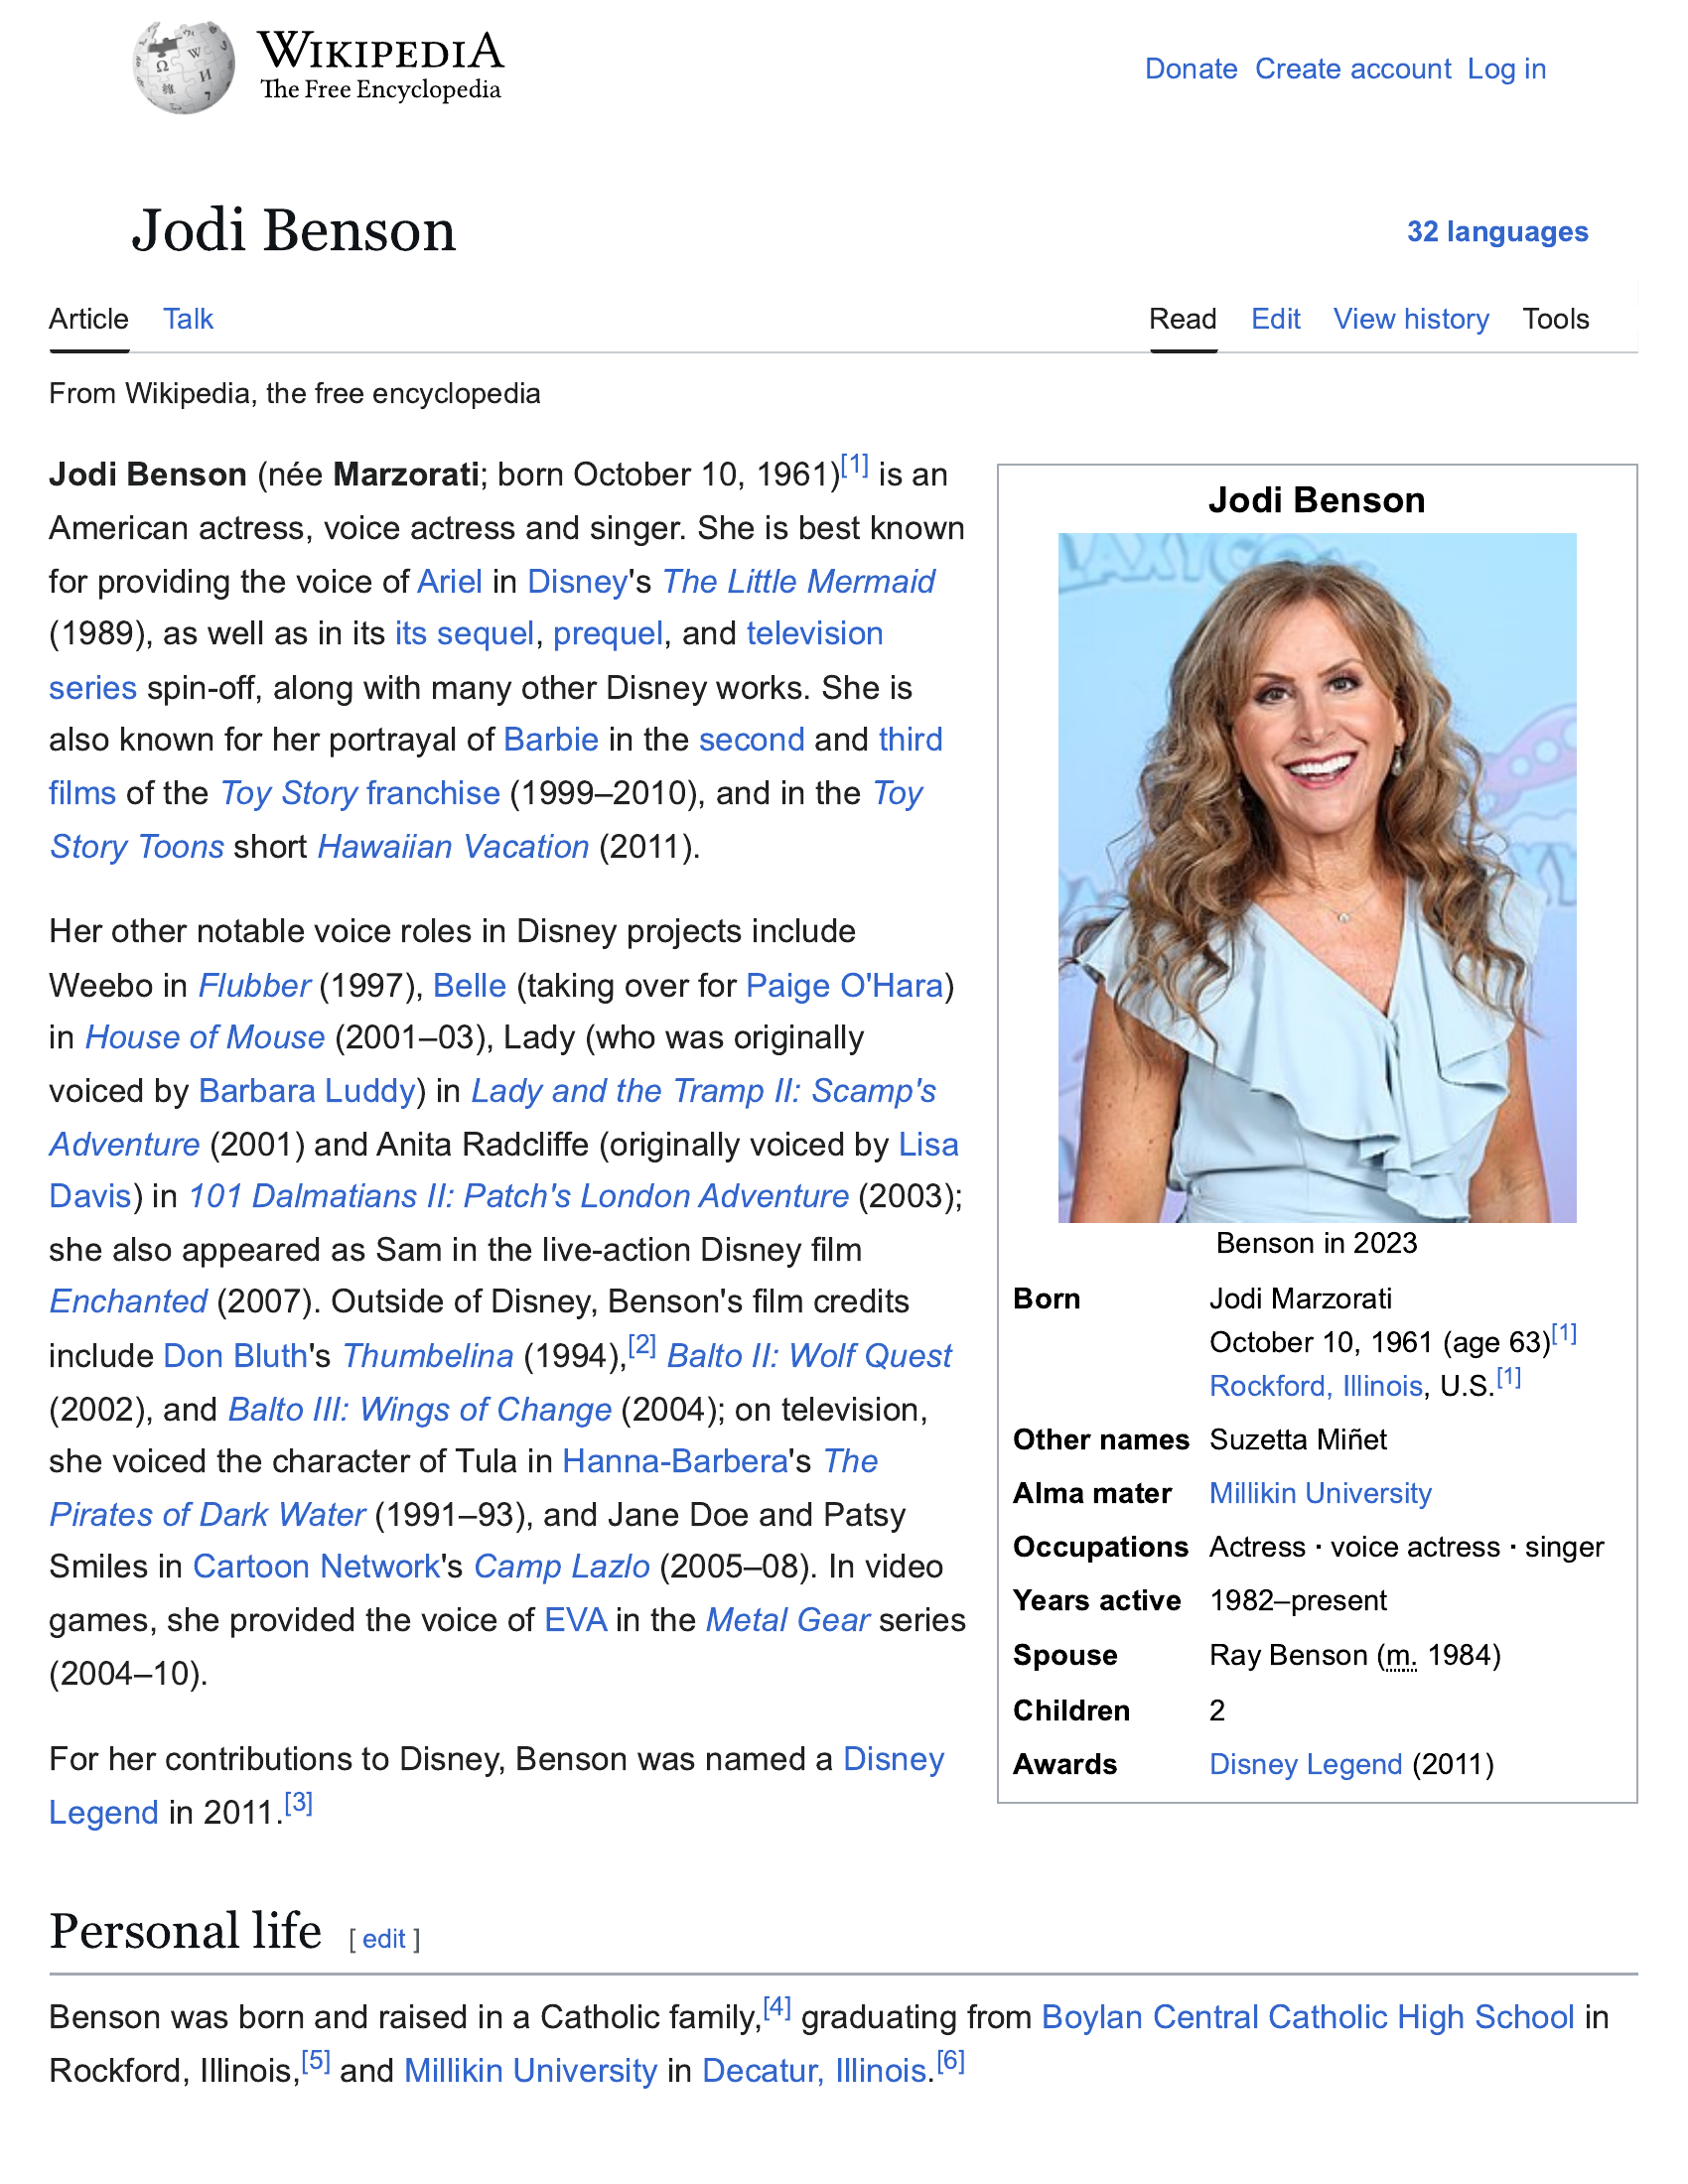

In [ ]:
images[0]

In [ ]:
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", trust_remote_code=True)

# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             # {"image": images[image_index]}, # This line is commented out in the image
#             {"type": "text", "text": text_query},
#         ]
#     }
# ]

# text = processor.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )

# image_inputs, video_inputs = process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     padding=True,
#     return_tensors="pt",
# )

# inputs = inputs.to("cuda")

# generated_ids = vlm.generate(**inputs, max_new_tokens=50)
# generated_ids_trimmed = [
#     out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]

# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )

# print(output_text)

In [ ]:
api_content_list = [
  {
      "type": "text",
      "text": text_query
  }
]

for result in retrieval_results:
  page_num = result['page_num']
  raw_base64_data = result['base64']

  if raw_base64_data:
      image_format = "png"

      base64_image_data_uri = f"data:image/{image_format};base64,{raw_base64_data}"

      api_content_list.append({
          "type": "image_url",
          "image_url": {
              "url": base64_image_data_uri,
              "detail": "high"
          }
      })
      print(f"- Đã thêm trang {page_num} vào context cho VLM.")
  else:
      print(f"Cảnh báo: page_num {page_num} có base64 rỗng hoặc null.")

- Đã thêm trang 5 vào context cho VLM.
- Đã thêm trang 7 vào context cho VLM.
- Đã thêm trang 8 vào context cho VLM.
- Đã thêm trang 6 vào context cho VLM.
- Đã thêm trang 4 vào context cho VLM.


In [ ]:
from openai import OpenAI
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')
OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')


client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=OPENROUTER_API_KEY,
)

print(f"\nĐang gửi {len(api_content_list) - 1} hình ảnh đến VLM...")

completion = client.chat.completions.create(
  extra_body={},
  model="qwen/qwen2.5-vl-32b-instruct:free",
  messages=[
    {
      "role": "user",
      "content": api_content_list
    }
  ],
  max_tokens=1000
)
print("\nPhản hồi từ VLM:")
print(completion.choices[0].message.content)


Đang gửi 5 hình ảnh đến VLM...

Phản hồi từ VLM:
### Analysis of the Provided Table

The task is to identify all distinct TV shows the person appeared on between January 1, 2011, and December 31, 2025, inclusive, based solely on the information in the table. We need to count the total number of these distinct TV shows and list each show along with the corresponding roles the person played.

#### Step 1: Identify TV Shows from the "Television" Section
The "Television" section of the table lists the TV shows and the roles the person played. We will focus on the shows appearing between 2011 and 2025.

**Television Section:**
- **2011**: *The Little Engine That Could* – Role: Jillian (voice)
- **2011**: *Toy Story Toons* – Role: Barbie (voice) – Episode: "Hawaiian Vacation"
- **2013-2018**: *Sofia the First* – Role: Ariel, Queen Emmaline (voice)
- **2015**: *Star vs. the Forces of Evil* – Role: Singing Teacher (voice)
- **2016**: *Clarence* – Role: Diana (voice) – Episode: "The Tails of M